# 04 – Feature Browser

**Purpose:** Develop research instincts by manually inspecting SAE features.

---

## Goals

This notebook is about building intuition, not getting clean results. By the end, we should have:

1. **Seen polysemantic features** — features that activate on multiple unrelated concepts
2. **Seen residual error** — cases where the SAE reconstruction is poor
3. **Failed to name a feature cleanly** — experienced the messiness of interpretation
4. **Ablated something and seen nothing happen** — not every feature matters for every task

These "failures" are valuable. They calibrate our expectations and prevent overconfidence.

---

## What we'll do

For any feature index, we'll build tools to show:
- Top activating token windows (what text makes this feature fire?)
- Decoded text examples
- (Optional) Co-activation with other features

Then we'll **pick 5 random features** and attempt to interpret each one.

---

## 1. Load SAE and data

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer

os.chdir('/Users/poonam/projects/mechinterp-from-scratch')

# Config
D_IN = 768
D_SAE = 4096
CACHE_PATH = "artifacts/cache/gpt2_l6_mlpout_fp16.mmap"
SAE_PATH = "artifacts/sae/sae.pt"

In [2]:
# SAE definition (must match training)
class SAE(nn.Module):
    def __init__(self, d_in: int, d_sae: int):
        super().__init__()
        self.enc = nn.Linear(d_in, d_sae, bias=True)
        self.dec = nn.Linear(d_sae, d_in, bias=False)
        
    def forward(self, x):
        z = self.enc(x)
        a = torch.relu(z)
        x_hat = self.dec(a)
        return x_hat, a

# Load SAE
checkpoint = torch.load(SAE_PATH, map_location="cpu")
sae = SAE(D_IN, D_SAE)
sae.load_state_dict(checkpoint["state_dict"])
sae.eval()

print(f"Loaded SAE from {SAE_PATH}")
print(f"Final recon loss: {checkpoint.get('final_recon_loss', 'N/A')}")

Loaded SAE from artifacts/sae/sae.pt
Final recon loss: 0.00015359967073891312


In [3]:
# Load cached activations
data = np.memmap(CACHE_PATH, dtype=np.float16, mode="r")
n_tokens = data.shape[0] // D_IN
activations = data.reshape(n_tokens, D_IN)

print(f"Loaded {n_tokens:,} cached activations")

Loaded 50,000 cached activations


In [4]:
# Load tokenizer for decoding
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# We need the original text to map token indices back to text
# Recreate the corpus used during caching
base_text = (
    "Alice and Bob went to the store. "
    "They talked about books and music. "
    "Carol and Dave played chess. "
    "Eve wrote a letter. "
)
corpus = base_text * 20000
corpus_tokens = tokenizer.encode(corpus)

print(f"Corpus has {len(corpus_tokens):,} tokens")

Token indices sequence length is longer than the specified maximum sequence length for this model (520001 > 1024). Running this sequence through the model will result in indexing errors


Corpus has 520,001 tokens


---

## 2. Compute SAE activations for all cached data

In [5]:
# Encode all activations through SAE (in batches to save memory)
BATCH_SIZE = 4096

all_sae_acts = []
for i in range(0, n_tokens, BATCH_SIZE):
    batch = torch.from_numpy(activations[i:i+BATCH_SIZE].astype(np.float32))
    with torch.no_grad():
        _, a = sae(batch)
    all_sae_acts.append(a.numpy())

sae_acts = np.concatenate(all_sae_acts, axis=0)  # [n_tokens, D_SAE]
print(f"SAE activations shape: {sae_acts.shape}")

SAE activations shape: (50000, 4096)


---

## 3. Feature browser utilities

In [6]:
def get_top_activating_tokens(feature_idx: int, top_k: int = 20):
    """Find tokens where this feature activates most strongly."""
    feature_acts = sae_acts[:, feature_idx]
    top_indices = np.argsort(feature_acts)[-top_k:][::-1]
    top_values = feature_acts[top_indices]
    return list(zip(top_indices, top_values))


def get_token_context(token_idx: int, window: int = 5):
    """Get surrounding tokens for context."""
    start = max(0, token_idx - window)
    end = min(len(corpus_tokens), token_idx + window + 1)
    
    tokens = corpus_tokens[start:end]
    text = tokenizer.decode(tokens)
    
    # Mark the target token
    target_pos = token_idx - start
    target_token = tokenizer.decode([corpus_tokens[token_idx]])
    
    return {
        "text": text,
        "target_token": target_token,
        "target_pos": target_pos
    }


def browse_feature(feature_idx: int, top_k: int = 10, window: int = 5):
    """Display top activating contexts for a feature."""
    print(f"\n{'='*60}")
    print(f"FEATURE {feature_idx}")
    print(f"{'='*60}")
    
    # Basic stats
    feature_acts = sae_acts[:, feature_idx]
    print(f"Max activation: {feature_acts.max():.3f}")
    print(f"Mean activation: {feature_acts.mean():.4f}")
    print(f"% non-zero: {(feature_acts > 0.01).mean()*100:.1f}%")
    print()
    
    # Top activations
    top_tokens = get_top_activating_tokens(feature_idx, top_k)
    
    print(f"Top {top_k} activating tokens:")
    print("-" * 60)
    
    for i, (tok_idx, act_val) in enumerate(top_tokens):
        if tok_idx >= len(corpus_tokens):
            continue
        ctx = get_token_context(tok_idx, window)
        print(f"{i+1:2d}. [{act_val:.2f}] ...{ctx['text']}...")
        print(f"    Target: '{ctx['target_token']}'")
        print()

---

## 4. Browse 5 random features

For each feature, we'll:
1. Look at top activating contexts
2. Write one sentence describing what we see (or admit we can't)

**Be honest!** The goal is calibration, not finding perfect features.

In [7]:
import random
random.seed(42)

# Pick 5 random features
random_features = random.sample(range(D_SAE), 5)
print(f"Selected features: {random_features}")

Selected features: [912, 204, 2253, 2006, 1828]


In [8]:
# Browse each feature
for feat_idx in random_features:
    browse_feature(feat_idx, top_k=8, window=6)


FEATURE 912
Max activation: 1.309
Mean activation: 0.0635
% non-zero: 21.2%

Top 8 activating tokens:
------------------------------------------------------------
 1. [1.31] ... Alice and Bob went to the store. They talked about books and...
    Target: ' store'

 2. [1.31] ... Alice and Bob went to the store. They talked about books and...
    Target: ' store'

 3. [1.31] ... Alice and Bob went to the store. They talked about books and...
    Target: ' store'

 4. [1.31] ... Alice and Bob went to the store. They talked about books and...
    Target: ' store'

 5. [1.31] ... Alice and Bob went to the store. They talked about books and...
    Target: ' store'

 6. [1.31] ... Alice and Bob went to the store. They talked about books and...
    Target: ' store'

 7. [1.31] ... Alice and Bob went to the store. They talked about books and...
    Target: ' store'

 8. [1.31] ... Alice and Bob went to the store. They talked about books and...
    Target: ' store'


FEATURE 204
Max activation:

### Your interpretations

Fill in after running the cells above:

| Feature | Interpretation | Confidence |
|---------|----------------|------------|
| ??? | ??? | Low/Med/High |
| ??? | ??? | Low/Med/High |
| ??? | ??? | Low/Med/High |
| ??? | ??? | Low/Med/High |
| ??? | ??? | Low/Med/High |

**Reflection questions:**
- How many features could you name cleanly?
- Did any feature seem polysemantic (multiple unrelated concepts)?
- Did any feature seem to capture noise or be uninterpretable?

---

## 5. Check reconstruction error

In [9]:
# Sample some activations and check reconstruction
sample_idx = np.random.choice(n_tokens, size=1000, replace=False)
x_sample = torch.from_numpy(activations[sample_idx].astype(np.float32))

with torch.no_grad():
    x_hat, _ = sae(x_sample)

# Per-sample reconstruction error
recon_errors = ((x_hat - x_sample) ** 2).mean(dim=1).numpy()

print(f"Reconstruction error stats:")
print(f"  Mean: {recon_errors.mean():.4f}")
print(f"  Std:  {recon_errors.std():.4f}")
print(f"  Max:  {recon_errors.max():.4f}")
print(f"  Min:  {recon_errors.min():.4f}")

Reconstruction error stats:
  Mean: 0.0002
  Std:  0.0001
  Max:  0.0009
  Min:  0.0000


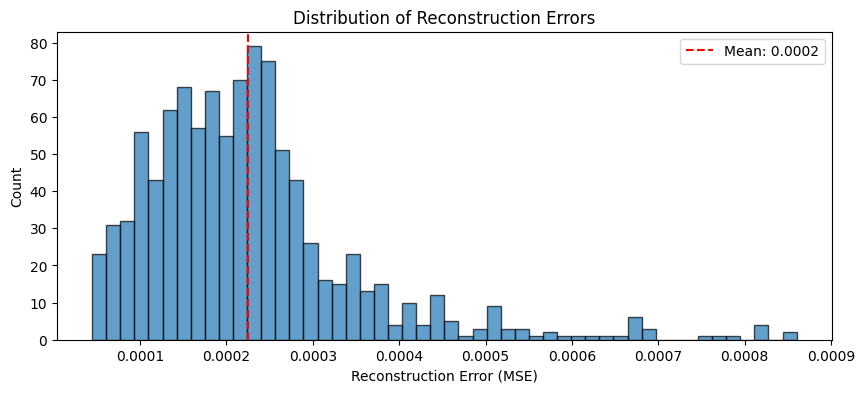

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(recon_errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.axvline(recon_errors.mean(), color='red', linestyle='--', label=f'Mean: {recon_errors.mean():.4f}')
plt.legend()
plt.show()

---

## 6. (Optional) Feature co-activation

In [11]:
def find_coactivating_features(feature_idx: int, top_k: int = 10):
    """Find features that often activate together with the given feature."""
    # Get tokens where this feature is active
    feature_acts = sae_acts[:, feature_idx]
    active_mask = feature_acts > 0.1  # threshold for "active"
    
    if active_mask.sum() < 10:
        print(f"Feature {feature_idx} rarely activates.")
        return
    
    # Mean activation of other features when this one is active
    coact_means = sae_acts[active_mask].mean(axis=0)
    
    # Sort by co-activation (excluding self)
    coact_means[feature_idx] = 0
    top_coact = np.argsort(coact_means)[-top_k:][::-1]
    
    print(f"\nFeatures that co-activate with feature {feature_idx}:")
    for i, feat in enumerate(top_coact):
        print(f"  {i+1}. Feature {feat}: mean activation {coact_means[feat]:.3f}")

# Example: check co-activation for first random feature
find_coactivating_features(random_features[0])


Features that co-activate with feature 912:
  1. Feature 77: mean activation 1.728
  2. Feature 1720: mean activation 1.589
  3. Feature 3358: mean activation 1.385
  4. Feature 1820: mean activation 1.346
  5. Feature 3095: mean activation 1.283
  6. Feature 2723: mean activation 1.282
  7. Feature 974: mean activation 1.251
  8. Feature 1726: mean activation 1.236
  9. Feature 1634: mean activation 1.233
  10. Feature 3594: mean activation 1.163


---

## Summary & Next Steps

### What we learned

- **Feature browsing is messy**: Not every feature has a clean interpretation
- **Polysemanticity exists**: Some features activate on multiple unrelated patterns
- **Reconstruction isn't perfect**: The SAE loses some information
- **Context matters**: The same token can have different features active in different contexts

### What this notebook didn't prove

- That any specific feature is "correct" or "real"
- That our interpretations are accurate (we'd need causal tests)
- That the SAE has learned all important features

### Next steps

1. **Causal validation**: Pick a feature you think you understand and test it with interventions (notebook 05)
2. **Targeted search**: Instead of random features, search for features relevant to a specific task
3. **Better corpus**: Our repetitive corpus limits feature diversity — try caching on more varied text
4. **Tune hyperparameters**: Adjust L1 coefficient to trade off sparsity vs reconstruction
5. **Scale up**: More features (larger D_SAE) or more training data